<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/CLV_Conformal_Prediction_Segmentation/CLV_CLUSTER_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap &> /dev/null

In [2]:
! pip install feature_engine &>/dev/null

In [3]:
! pip install optuna &>/dev/null

In [4]:
! pip install MAPIE &>/dev/null

In [5]:
! pip install gower &>/dev/null

In [6]:
! pip install dtaidistance &>/dev/null

In [7]:
! pip install scikit-learn-extra &>/dev/null

In [8]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import scipy
from scipy.stats import shapiro
import scipy.stats as stats
import feature_engine
from feature_engine.timeseries.forecasting import WindowFeatures
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import TweedieRegressor
import lightgbm
import xgboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import mapie
from mapie.metrics import (coverage_width_based, regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import dtaidistance
from dtaidistance import dtw
from sklearn.manifold import Isomap
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import optuna
import shap
import pickle

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [9]:
np.__version__

'1.26.4'

In [10]:
pd.__version__

'2.2.2'

In [11]:
matplotlib.__version__

'3.8.0'

In [12]:
sns.__version__

'0.13.2'

In [13]:
scipy.__version__

'1.13.1'

In [14]:
feature_engine.__version__

'1.8.2'

In [15]:
sklearn.__version__

'1.5.2'

In [16]:
lightgbm.__version__

'4.5.0'

In [17]:
xgboost.__version__

'2.1.2'

In [18]:
mapie.__version__

'0.9.1'

In [19]:
statsmodels.__version__

'0.14.4'

In [20]:
dtaidistance.__version__

'2.3.12'

In [21]:
optuna.__version__

'4.0.0'

In [22]:
shap.__version__

'0.46.0'

In [23]:
# dataset
df_0=pd.read_csv('/content/AutoInsurance.csv',index_col=0)

###Data Cleaning & Handling Variables

In [24]:
# Cast datetime variable in datetime format
df_1 = df_0.copy()
# Reset index to bring `Customer` into the columns
df_1 = df_1.reset_index()
df_1['Effective_Date'] = pd.to_datetime(df_1['Effective To Date'])
df_1 = df_1.sort_values(by='Effective_Date')
# Sanity check: data span
df_1.Effective_Date.min(), df_1.Effective_Date.max()



(Timestamp('2011-01-01 00:00:00'), Timestamp('2011-12-02 00:00:00'))

In [25]:
df_1 = df_1.drop(['Customer','Effective To Date'], axis=1)

In [26]:
# Rename some features for a practical use
df_2 = df_1.copy()
df_2 = df_2.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

In [27]:
df_clustering=df_2.copy()
df_cluster=df_2.copy()

### Functions

In [28]:
def cluster_weight(data, varcluster, var):
  data_group = data.groupby(data[varcluster], as_index=False)[var].sum()
  data_group['PERCENTAGE'] = data_group[var]/data_group[var].sum()*100
  # dropping not matching rows
  data_group = data_group.dropna()
  # ranking
  data_g = data_group.sort_values(by = var, ascending = False).reset_index(drop=True)
  return data_g

In [29]:
def plot_grouped_data(df, column, varcluster, title, ylabel):

    grouped = df.groupby([pd.Grouper(freq='W'), varcluster])[column].sum().reset_index()

    # Plotting
    plt.figure(figsize=(5, 5))
    for cluster in grouped[varcluster].unique():
        cluster_data = grouped[grouped[varcluster] == cluster]
        plt.plot(cluster_data['Effective_Date'], cluster_data[column], marker='o', label=f'varcluster {cluster}')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Week')
    plt.ylabel(ylabel)
    plt.legend(title=varcluster)
    plt.xticks(rotation=45)
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()



### Label Encoding

In [30]:
label_encoder_State = LabelEncoder()
label_encoder_Response = LabelEncoder()
label_encoder_Coverage = LabelEncoder()
label_encoder_Education = LabelEncoder()
label_encoder_EmploymentStatus = LabelEncoder()
label_encoder_Gender = LabelEncoder()
label_encoder_Location_Code = LabelEncoder()
label_encoder_Marital_Status = LabelEncoder()
label_encoder_Policy_Type = LabelEncoder()
label_encoder_Policy = LabelEncoder()
label_encoder_Renew_Offer_Type = LabelEncoder()
label_encoder_Sales_Channel = LabelEncoder()
label_encoder_Vehicle_Class = LabelEncoder()
label_encoder_Vehicle_Size = LabelEncoder()


df_clustering['State_ed'] = label_encoder_State.fit_transform(df_clustering['State'])
df_clustering['Response_ed'] = label_encoder_Response.fit_transform(df_clustering['Response'])
df_clustering['Coverage_ed'] = label_encoder_Coverage.fit_transform(df_clustering['Coverage'])
df_clustering['Education_ed'] = label_encoder_Education.fit_transform(df_clustering['Education'])
df_clustering['EmploymentStatus_ed'] = label_encoder_EmploymentStatus.fit_transform(df_clustering['EmploymentStatus'])
df_clustering['Gender_ed'] = label_encoder_Gender.fit_transform(df_clustering['Gender'])
df_clustering['Location_Code_ed'] = label_encoder_Location_Code.fit_transform(df_clustering['Location_Code'])
df_clustering['Marital_Status_ed'] = label_encoder_Marital_Status.fit_transform(df_clustering['Marital_Status'])
df_clustering['Policy_Type_ed'] = label_encoder_Policy_Type.fit_transform(df_clustering['Policy_Type'])
df_clustering['Policy_ed'] = label_encoder_Policy.fit_transform(df_clustering['Policy'])
df_clustering['Renew_Offer_Type_ed'] = label_encoder_Renew_Offer_Type.fit_transform(df_clustering['Renew_Offer_Type'])
df_clustering['Sales_Channel_ed'] = label_encoder_Sales_Channel.fit_transform(df_clustering['Sales_Channel'])
df_clustering['Vehicle_Class_ed'] = label_encoder_Vehicle_Class.fit_transform(df_clustering['Vehicle_Class'])
df_clustering['Vehicle_Size_ed'] = label_encoder_Vehicle_Size.fit_transform(df_clustering['Vehicle_Size'])



In [31]:
categorical_features=df_clustering[['State', 'Response',
       'Coverage', 'Education', 'EmploymentStatus', 'Gender',
       'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy',
       'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class',
       'Vehicle_Size']]
encoded_features=df_clustering[['State_ed', 'Response_ed',
       'Coverage_ed', 'Education_ed', 'EmploymentStatus_ed', 'Gender_ed',
       'Location_Code_ed', 'Marital_Status_ed', 'Policy_Type_ed', 'Policy_ed',
       'Renew_Offer_Type_ed', 'Sales_Channel_ed', 'Vehicle_Class_ed',
       'Vehicle_Size_ed']]
numerical_features=df_clustering[['Customer_Lifetime_Value','Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim',
'Months_Since_Policy_Inception', 'Number_of_Open_Complaints','Number_of_Policies','Total_Claim_Amount']]
scaler = StandardScaler()
normalized_time = scaler.fit_transform(df_clustering[['Effective_Date']].apply(pd.to_datetime).apply(lambda x: x.map(pd.Timestamp.toordinal)))
numerical_scaled_features = scaler.fit_transform(df_clustering[['Customer_Lifetime_Value','Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim',
'Months_Since_Policy_Inception', 'Number_of_Open_Complaints','Number_of_Policies','Total_Claim_Amount']])

In [32]:
X=np.hstack((encoded_features, numerical_scaled_features))

### Matrix Preparation for Clustering Data: Gower's Distance, Embedding, Dynamic Time Warping

In [33]:
distance_matrix = gower.gower_matrix(X)

In [34]:
embedding = Isomap(n_components=1, n_neighbors=10)
ISO_feature = embedding.fit_transform(distance_matrix)
X_ts= np.hstack((normalized_time,encoded_features, numerical_scaled_features,ISO_feature))
dtw_distances = dtw.distance_matrix_fast(X_ts)

### KMedoids

##### Elbow Method

In [35]:
# Cluster using different k values
inertias = []
K = range(1, 11)  # Example range, adjust as necessary
for k in K:
    kmedoids = KMedoids(n_clusters=k, metric='precomputed',method='pam',init='build', random_state=0)
    kmedoids.fit(dtw_distances)
    inertias.append(kmedoids.inertia_)

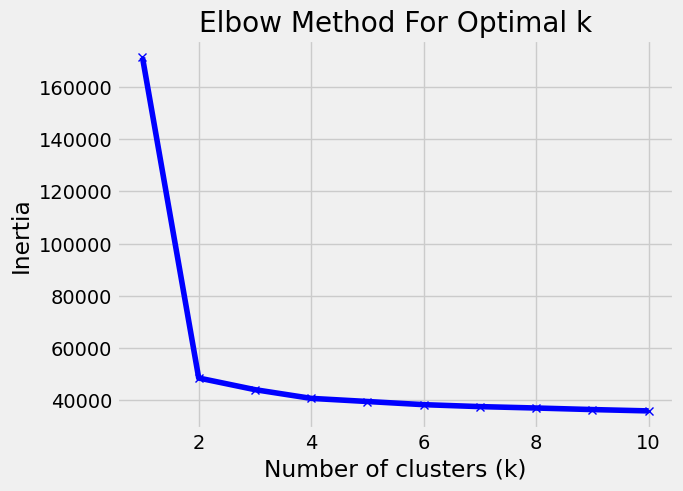

In [36]:
# Plot elbow method
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Silhouette Score

In [37]:
# Range of clusters to try
K = range(2, 11)  # Start from 2 because silhouette score is not defined for k=1
silhouette_scores = []

# Perform clustering and calculate silhouette scores
for k in K:
    kmedoids = KMedoids(n_clusters=k, metric='precomputed',method='pam',init='build', random_state=0)
    labels = kmedoids.fit_predict(distance_matrix)
    score = silhouette_score(dtw_distances, labels, metric="precomputed",method='pam',init='build',random_state=0)
    silhouette_scores.append(score)


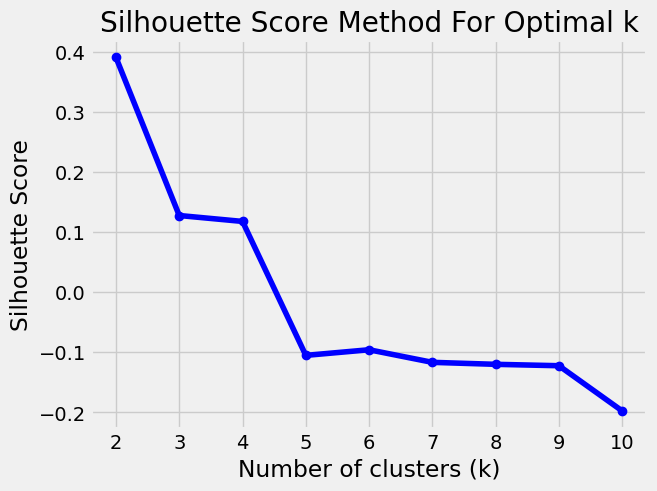

In [38]:
# Plot silhouette scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()

In [39]:
clusters_KM = (KMedoids(n_clusters=2,
                           metric='precomputed',
                           method='pam', init='build',
                           max_iter=100,
                           random_state=0)
            .fit(dtw_distances)
            .labels_)

In [40]:
# Evaluate clusters using silhouette score
sil_score = silhouette_score(dtw_distances, clusters_KM, metric='precomputed')
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.8098335647011873


In [41]:
# Add the cluster labels to the dataframe
df_cluster['Cluster_KM'] = clusters_KM

# Display the first few rows with cluster labels
df_cluster.head()

,State,Customer_Lifetime_Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location_Code,Marital_Status,...,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size,Effective_Date,Cluster_KM
4379,Washington,8693.995589,No,Basic,Bachelor,Employed,M,48893,Suburban,Married,...,3,Personal Auto,Personal L3,Offer1,Branch,787.889530,SUV,Medsize,2011-01-01,1
904,Arizona,3837.357574,No,Extended,High School or Below,Medical Leave,M,23051,Suburban,Divorced,...,1,Personal Auto,Personal L1,Offer1,Agent,475.200000,Two-Door Car,Medsize,2011-01-01,1
3639,Oregon,4594.263722,No,Basic,High School or Below,Unemployed,F,0,Rural,Married,...,3,Personal Auto,Personal L2,Offer4,Call Center,139.331764,Four-Door Car,Medsize,2011-01-01,0
3637,Oregon,2467.459952,No,Basic,Bachelor,Unemployed,M,0,Suburban,Single,...,1,Personal Auto,Personal L2,Offer1,Agent,525.600000,Two-Door Car,Medsize,2011-01-01,1
6552,Washington,20096.893370,Yes,Basic,High School or Below,Employed,F,92766,Suburban,Married,...,2,Personal Auto,Personal L2,Offer2,Agent,379.029102,Two-Door Car,Large,2011-01-01,0


In [42]:
df_cluster.set_index('Effective_Date', inplace=True)

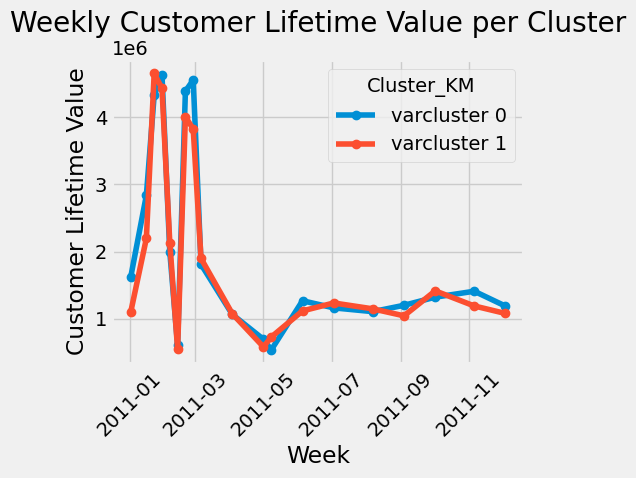

In [43]:
plot_grouped_data(df_cluster, 'Customer_Lifetime_Value', 'Cluster_KM','Weekly Customer Lifetime Value per Cluster', 'Customer Lifetime Value')


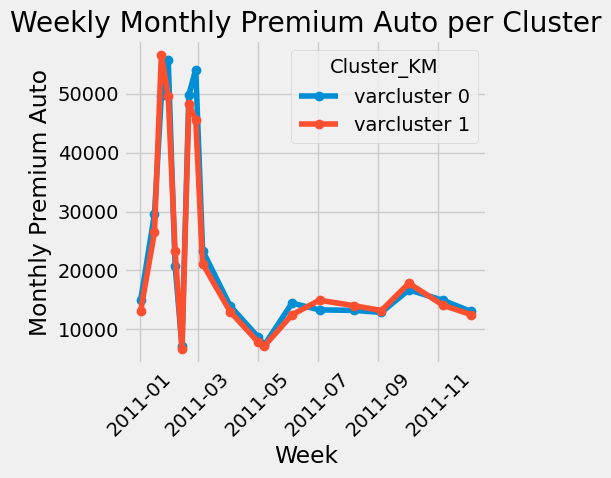

In [44]:
plot_grouped_data(df_cluster, 'Monthly_Premium_Auto', 'Cluster_KM','Weekly Monthly Premium Auto per Cluster', 'Monthly Premium Auto')


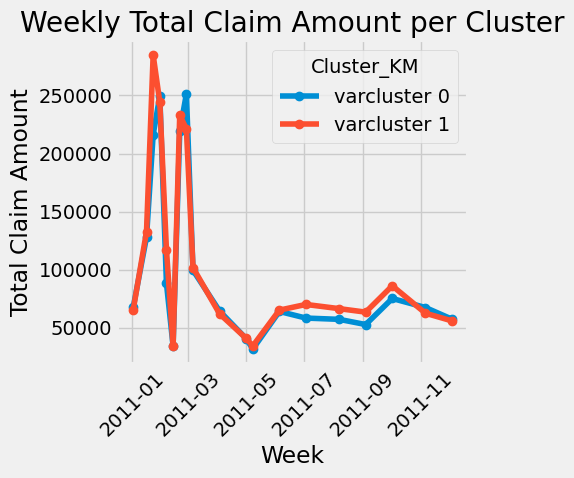

In [45]:
plot_grouped_data(df_cluster, 'Total_Claim_Amount', 'Cluster_KM','Weekly Total Claim Amount per Cluster', 'Total Claim Amount')

In [46]:
cluster_weight(data=df_cluster, varcluster='Cluster_KM', var='Customer_Lifetime_Value')

,Cluster_KM,Customer_Lifetime_Value,PERCENTAGE
0,0,3.771397e+07,51.580219
1,1,3.540315e+07,48.419781


In [47]:
cluster_weight(data=df_cluster, varcluster='Cluster_KM', var='Monthly_Premium_Auto')

,Cluster_KM,Monthly_Premium_Auto,PERCENTAGE
0,0,433600,50.923996
1,1,417865,49.076004


In [48]:
cluster_weight(data=df_cluster, varcluster='Cluster_KM', var='Total_Claim_Amount')

,Cluster_KM,Total_Claim_Amount,PERCENTAGE
0,1,2.041882e+06,51.498071
1,0,1.923085e+06,48.501929


### Hierarchical Agglomerative Clustering

#### Dendogram

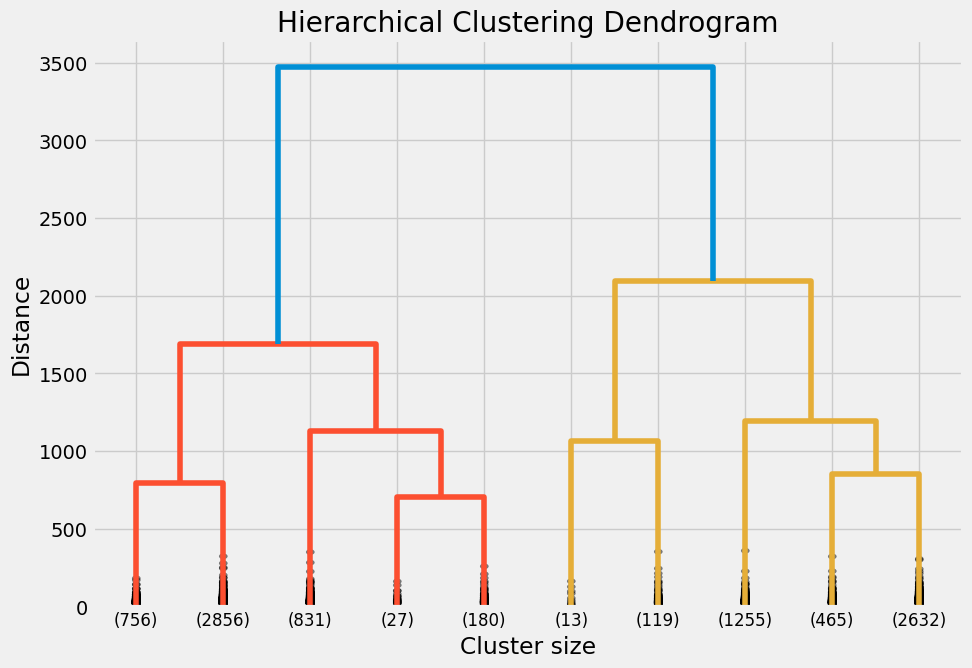

In [49]:
# Compute the linkage matrix using Ward's method
np.random.seed(0)
Z = linkage(dtw_distances, method='complete')

# Plot the dendrogram to decide the number of clusters
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='lastp', p=10, show_contracted=True)
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()



#### Silhouette Score

In [50]:
# Range of clusters to try
np.random.seed(0)
K = range(2, 11)  # Start from 2 because silhouette score is not defined for k=1
silhouette_scores = []

# Perform clustering and calculate silhouette scores using Agglomerative Clustering with Ward linkage
for k in K:
    # Initialize AgglomerativeClustering with Ward linkage
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='complete', metric='precomputed')
    # Fit and predict the labels
    labels = agg_clustering.fit_predict(dtw_distances)
    # Calculate silhouette score
    score = silhouette_score(dtw_distances, labels)
    silhouette_scores.append(score)



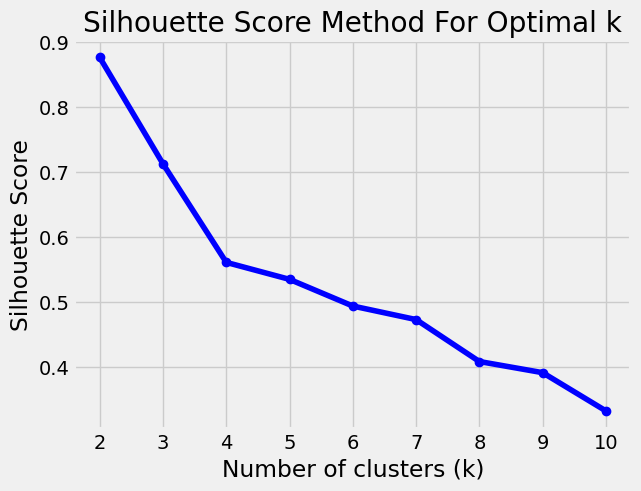

In [51]:
# Plot silhouette scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()

In [52]:
clusters_HAC = (AgglomerativeClustering(n_clusters=2, linkage='complete', metric='precomputed').fit_predict(dtw_distances))

In [53]:
# Evaluate clusters using silhouette score
sil_score = silhouette_score(dtw_distances, clusters_HAC, metric='precomputed')
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.809005063887715


In [54]:
# Add the cluster labels to the dataframe
df_cluster['Cluster_HAC'] = clusters_HAC

# Display the first few rows with cluster labels
df_cluster.head()

,State,Customer_Lifetime_Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location_Code,Marital_Status,...,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size,Cluster_KM,Cluster_HAC
Effective_Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,Washington,8693.995589,No,Basic,Bachelor,Employed,M,48893,Suburban,Married,...,3,Personal Auto,Personal L3,Offer1,Branch,787.889530,SUV,Medsize,1,0
2011-01-01,Arizona,3837.357574,No,Extended,High School or Below,Medical Leave,M,23051,Suburban,Divorced,...,1,Personal Auto,Personal L1,Offer1,Agent,475.200000,Two-Door Car,Medsize,1,0
2011-01-01,Oregon,4594.263722,No,Basic,High School or Below,Unemployed,F,0,Rural,Married,...,3,Personal Auto,Personal L2,Offer4,Call Center,139.331764,Four-Door Car,Medsize,0,1
2011-01-01,Oregon,2467.459952,No,Basic,Bachelor,Unemployed,M,0,Suburban,Single,...,1,Personal Auto,Personal L2,Offer1,Agent,525.600000,Two-Door Car,Medsize,1,0
2011-01-01,Washington,20096.893370,Yes,Basic,High School or Below,Employed,F,92766,Suburban,Married,...,2,Personal Auto,Personal L2,Offer2,Agent,379.029102,Two-Door Car,Large,0,1


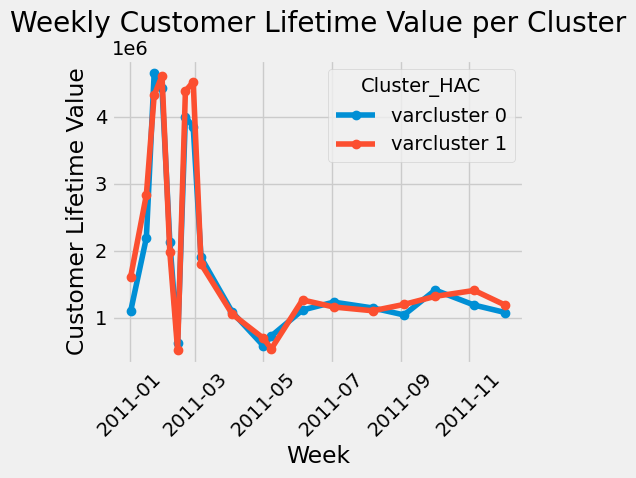

In [55]:
plot_grouped_data(df_cluster, 'Customer_Lifetime_Value', 'Cluster_HAC','Weekly Customer Lifetime Value per Cluster', 'Customer Lifetime Value')


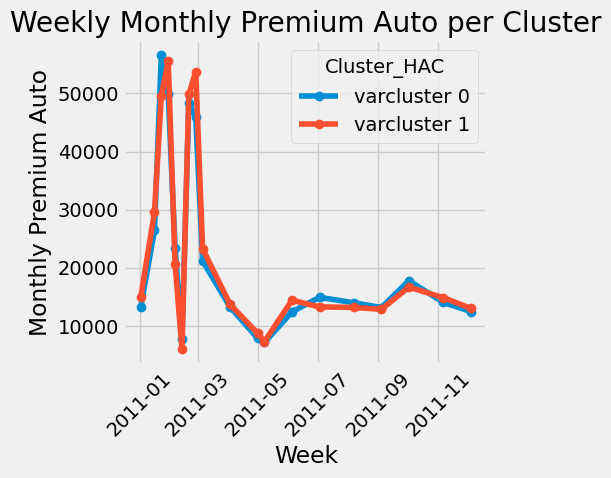

In [56]:
plot_grouped_data(df_cluster, 'Monthly_Premium_Auto', 'Cluster_HAC','Weekly Monthly Premium Auto per Cluster', 'Monthly Premium Auto')


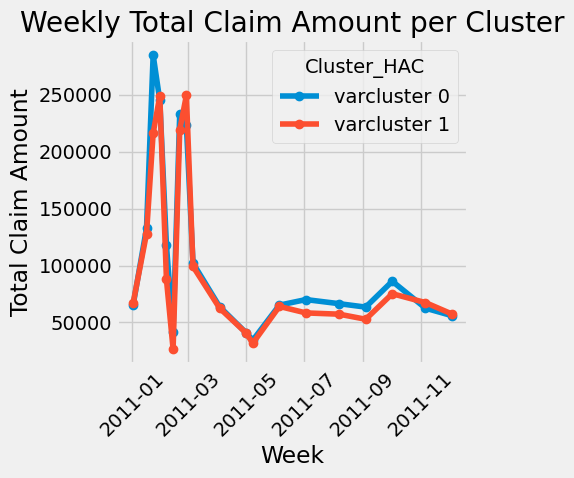

In [57]:
plot_grouped_data(df_cluster, 'Total_Claim_Amount', 'Cluster_HAC','Weekly Total Claim Amount per Cluster', 'Total Claim Amount')

In [58]:
cluster_weight(data=df_cluster, varcluster='Cluster_HAC', var='Customer_Lifetime_Value')

,Cluster_HAC,Customer_Lifetime_Value,PERCENTAGE
0,1,3.756917e+07,51.382181
1,0,3.554795e+07,48.617819


In [59]:
cluster_weight(data=df_cluster, varcluster='Cluster_HAC', var='Monthly_Premium_Auto')

,Cluster_HAC,Monthly_Premium_Auto,PERCENTAGE
0,1,431514,50.679006
1,0,419951,49.320994


In [60]:
cluster_weight(data=df_cluster, varcluster='Cluster_HAC', var='Total_Claim_Amount')

,Cluster_HAC,Total_Claim_Amount,PERCENTAGE
0,0,2.054929e+06,51.827137
1,1,1.910038e+06,48.172863


In [66]:
df_0['Cluster_KM'] = clusters_KM

In [67]:
df_0['Cluster_HAC'] = clusters_HAC

In [69]:
# Save the fitted model to a file
filename = 'clusters_KM_model.sav'
pickle.dump(clusters_KM, open(filename, 'wb'))

In [70]:
# Save the fitted model to a file
filename = 'clusters_HAC_model.sav'
pickle.dump(clusters_HAC, open(filename, 'wb'))

In [71]:
df_0.to_csv('/content/AutoInsurance_cluster.csv', index=True)

### References

https://mapie.readthedocs.io/en/latest/index.html

https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction

https://christophmolnar.com/books/conformal-prediction/

https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles